In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff
import math
import re
from pandas.core.frame import DataFrame
from sklearn.neighbors import LocalOutlierFactor

**Basic satastic information** 
* Each Data Distribution  
* Monthly trend (Monthly mean & sum)  &  Monthly category sells, Monthly shop sells
* Checking for outliers  
* Missing values? Errors? (filter the Datasets) : one price lower than 0, few higherst price ?

## 1 Load Data

In [2]:
item_cat=pd.read_csv("../datasets/item_categories.csv")
item=pd.read_csv("../datasets/items.csv")
sub=pd.read_csv("../datasets/sample_submission.csv")
shops=pd.read_csv("../datasets/shops.csv")
test=pd.read_csv("../datasets/test.csv")
sales=pd.read_csv("../datasets/sales_train.csv")
monthly_sales = sales.groupby(["date_block_num","shop_id","item_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})
monthly_sales_simple = sales.groupby(["date_block_num"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/var/folders/z4/snjl44yd2sz6dxh5_3nlrgyh0000gn/T/ipykernel_10715/1621412518.py:7: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.

/var/folders/z4/snjl44yd2sz6dxh5_3nlrgyh0000gn/T/ipykernel_10715/1621412518.py:9: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



## 2 Data Distribution

### 2.1 Item and Item category

In [33]:
print('number of item category: ', len(item_cat))
print('number of item: ', len(item))

number of item category:  84
number of item:  22170


#### Generating Distribution 
Using data_disribution() to generate each column's distribution  
Using draw_distribution() to generate each file's s(dataset) distributions, and save as ./fig/file_name.jpg

In [34]:
def data_disribution(data, largest=0, label_inform=[''], log = False, dispaly = False):
    ## draw the data distribution
    #  data:  a column list
    #  largest:  only draw top N values. 0 means draw all the data
    #  log:  set_yscale('log')
    distance_dic = {}
    ini = -1
    for i in data:
        if i != ini:
            ini = i
            distance_dic[i] = data.count(i)
            # distance_list.append(i)

    if largest:
        distance_dic_sort = dict(sorted(distance_dic.items(), key=lambda x: x[1], reverse=True)[:largest])
        distance_dic_sort_key = {}
        for key in sorted(distance_dic_sort):
            distance_dic_sort_key[key] = distance_dic_sort[key]

        f_p = plt.gca()
        f_p.bar(range(0, len(distance_dic_sort_key.keys()), 1),distance_dic_sort_key.values(), width=0.7, color='b')        # f_p.set_yscale('log')
        if log:
            f_p.set_yscale('log')
        plt.title(label_inform[0])
        plt.ylabel(label_inform[1])
        plt.xlabel(label_inform[2])
        plt.savefig('../fig/'+label_inform[0]+'.jpg')
        if dispaly:
            plt.show() 
        return

    f_p = plt.gca()
    f_p.bar(range(0, len(distance_dic.keys()), 1),distance_dic.values(), width=0.7, color='b')
    if log:
        f_p.set_yscale('log')
    plt.title(label_inform[0])
    plt.ylabel(label_inform[1])
    plt.xlabel(label_inform[2])
    plt.savefig('../fig/'+label_inform[0]+'.jpg')
    if dispaly:
        plt.show()


def draw_distribution(data, log=False):
    for i in (data.columns.values):
        plot_information = [i, 'frequency', 'counts']
        data_sort = data.sort_values(i)
        data_disribution(list(data_sort[i]),30, plot_information, log = False, dispaly=False)
        print(i, 'save successful')

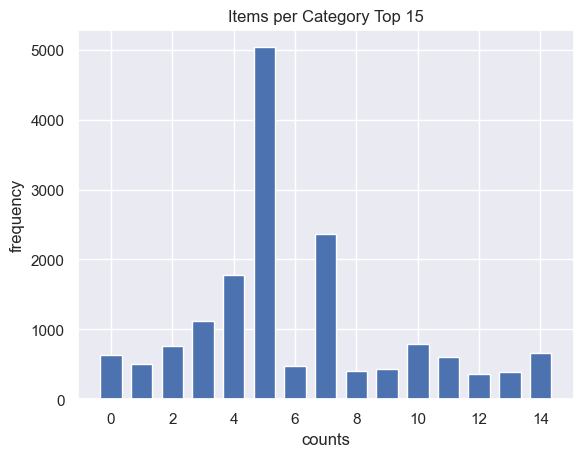

In [8]:
# Items per Category
item_sort = item.sort_values('item_category_id')
plot_information = ['Items per Category Top 15', 'frequency', 'counts']
data_disribution(list(item_sort['item_category_id']),15, plot_information, log = False, dispaly=True)

In [11]:
item_cat[item_cat['item_category_id'] == 5]

,item_category_name,item_category_id
5,Аксессуары - PSVita,5


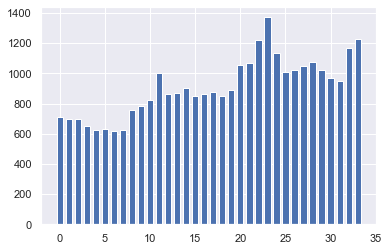

In [30]:
item_sort = monthly_sales_simple.sort_values('item_price')[:30]
f_p = plt.gca()
f_p.bar(range(len(monthly_sales_simple['item_price'])),monthly_sales_simple['item_price'], width=0.7, color='b')
plt.show()

In [35]:
cnt_sort_index = sorted(range(len(sales['item_cnt_day'])), key=lambda k: sales['item_cnt_day'][k], reverse=True)[:100]
price_sort_index = sorted(range(len(sales['item_price'])), key=lambda k: sales['item_price'][k], reverse=True)[:100]

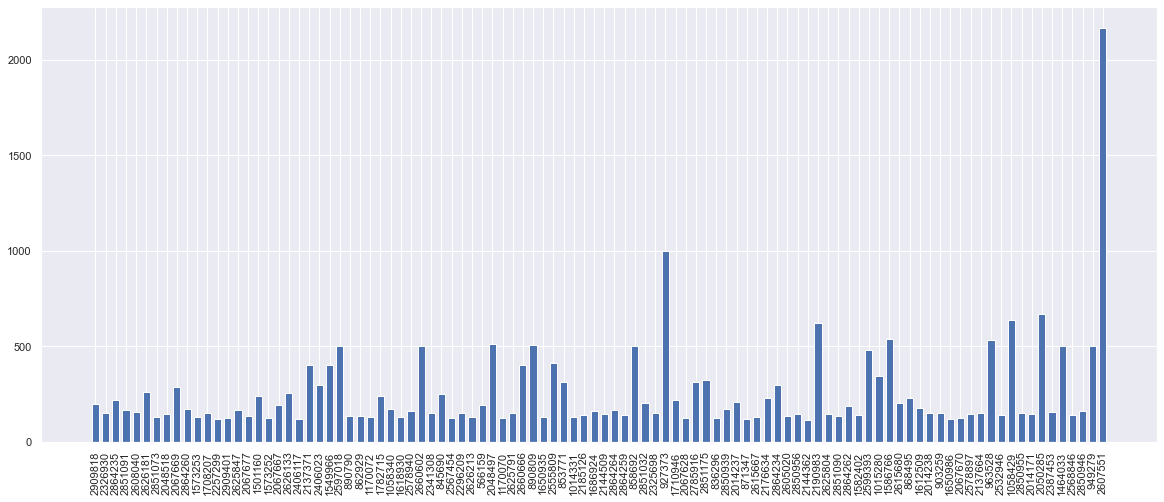

In [40]:
cnt_sort = sales.loc[sorted(cnt_sort_index)]
cnt_shop = sales.loc[cnt_sort_index]['shop_id']
cnt_item = sales.loc[cnt_sort_index]['item_id']
plt.figure(figsize=(20, 8))
f_p = plt.gca()
f_p.bar(range(len(cnt_sort['item_cnt_day'])),cnt_sort['item_cnt_day'], width=0.7, color='b')
plt.xticks(range(len(cnt_sort['item_cnt_day'])), cnt_sort_index, rotation=90)

plt.show()

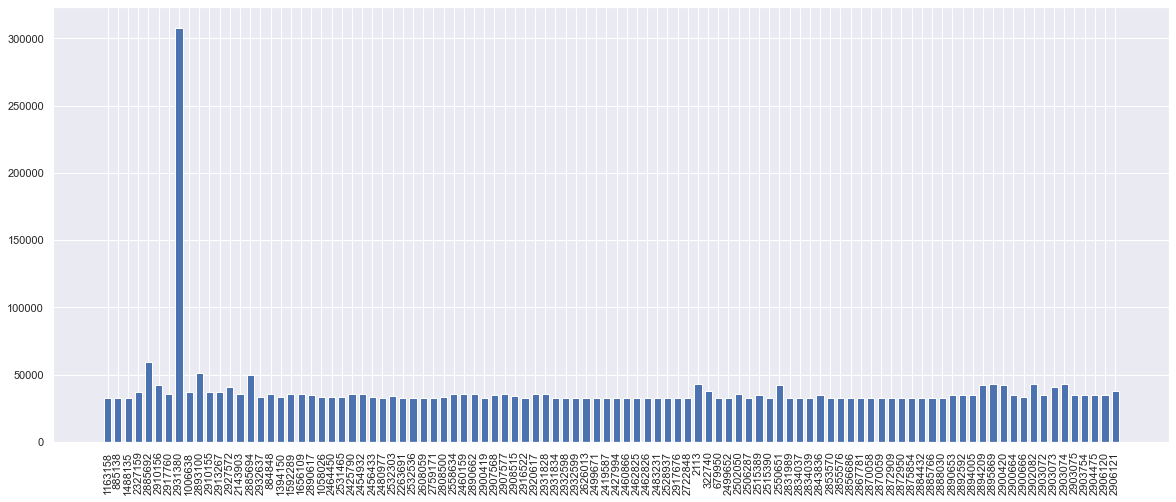

In [127]:
price_sort = sales.loc[sorted(price_sort_index)]
price_item = sales.loc[price_sort_index]['item_id']
price_shop = sales.loc[price_sort_index]['shop_id']
plt.figure(figsize=(20, 8))
f_p = plt.gca()
f_p.bar(range(len(price_sort['item_price'])),price_sort['item_price'], width=0.7, color='b')
plt.xticks(range(len(price_sort['item_price'])), price_sort_index, rotation=90)
plt.show()

We found two unreasonable value  
item_id1 = 11373  index = 2909818  
item_id2 = 6066  index = 1163158

### First outlier, select by cnt_item_day

In [36]:
# Firsy outlier item
sales.loc[2909818]

date              28.10.2015
date_block_num            33
shop_id                   12
item_id                11373
item_price          0.908714
item_cnt_day          2169.0
Name: 2909818, dtype: object

In [37]:
sales[sales['item_cnt_day'] == 539.0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2626181,19.05.2015,28,12,11373,155.19295,539.0


In [38]:
# item name (Delivery to the point of issue (Boxberry))
item[item['item_id'] == 11373]

,item_name,item_id,item_category_id
11373,Доставка до пункта выдачи (Boxberry),11373,9


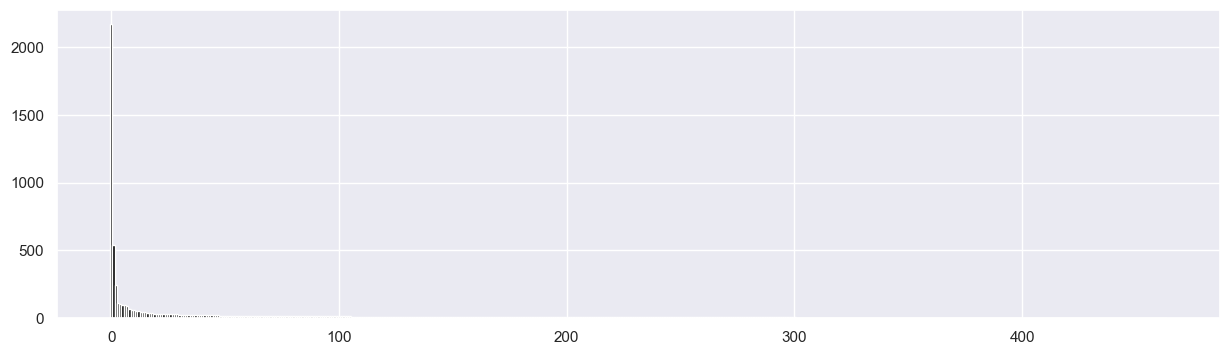

In [21]:
# All item 11373 sales
plt.figure(figsize=(15, 4))
f_p = plt.gca()
# f_p.set_yscale('log')
sort_item_11373 = sorted(sales[sales['item_id'] == 11373]['item_cnt_day'], reverse=True)
f_p.bar(range(len(sales[sales['item_id'] == 11373])), sort_item_11373,  width=1, color='black')
plt.show()

In [87]:
# shop name (E-shop online)
shops[shops['shop_id'] == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [88]:
# category name (Delivery of goods)
item_cat[item_cat['item_category_id'] == 9]

,item_category_name,item_category_id
9,Доставка товара,9


In [22]:
# median of item 11373
print('median of item 11373: ', DataFrame(sort_item_11373).median()[0])
# mean of item 11373
print('mean of item 11373: ', DataFrame(sort_item_11373).mean()[0])
# mean of item 11373 without maximum value
print('mean of item 11373 without maximum value: ', DataFrame(sort_item_11373)[2:].mean()[0])

median of item 11373:  4.0
mean of item 11373:  14.144396551724139
mean of item 11373 without maximum value:  8.344155844155845


In [23]:
# median of item 11373
print('median of item 11373: ', DataFrame(sort_item_11373).median()[0])
# mean of item 11373
print('mean of item 11373: ', DataFrame(sort_item_11373).mean()[0])
# mean of item 11373 without maximum value
print('mean of item 11373 without maximum value: ', DataFrame(sort_item_11373)[1:].mean()[0])

median of item 11373:  4.0
mean of item 11373:  14.144396551724139
mean of item 11373 without maximum value:  9.490280777537796


Then item 11373 on 28.10.2015 could be outlier

we can find it a online shop

### Another outlier, select by item_price

In [144]:
sales.loc[1163158]

date              13.12.2013
date_block_num            11
shop_id                   12
item_id                 6066
item_price          307980.0
item_cnt_day             1.0
Name: 1163158, dtype: object

In [147]:
# item name (kind of VPN)
item[item['item_id'] == 6066]

,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


In [150]:
# shop name (E-shop online)
shops[shops['shop_id'] == 12]

,shop_name,shop_id
12,Интернет-магазин ЧС,12


In [148]:
# category name (Programs - For home and office)
item_cat[item_cat['item_category_id'] == 75]

,item_category_name,item_category_id
75,Программы - Для дома и офиса,75


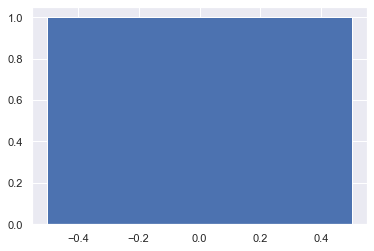

In [156]:
# All item 6066 sales
# plt.figure(figsize=(15, 4))
f_p = plt.gca()
# f_p.set_yscale('log')
sort_item_6066 = sorted(sales[sales['item_id'] == 6066]['item_cnt_day'], reverse=True)
f_p.bar(range(len(sales[sales['item_id'] == 6066])), sort_item_6066,  width=1, color='b')
plt.show()

sold only once, remove is justified

---

## 3 Monthly Trend  
* Price and item_cnt_day

In [6]:
block_cnt_sum = sales.groupby(["date_block_num"])["item_cnt_day"].sum()
block_cnt_mean = sales.groupby(["date_block_num"])["item_cnt_day"].mean()
block_price_sum = sales.groupby(["date_block_num"])["item_price"].sum()
block_price_mean = sales.groupby(["date_block_num"])["item_price"].mean()

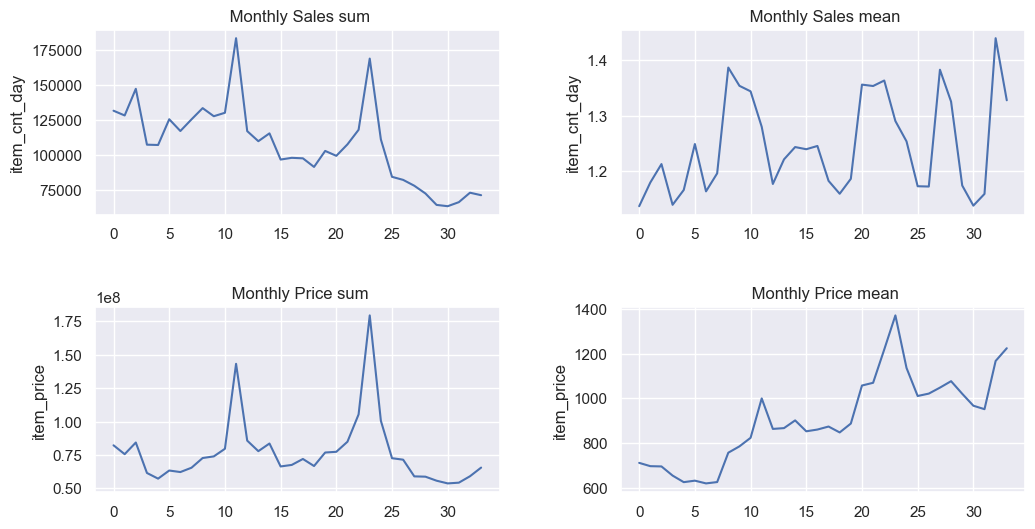

In [7]:
# Monthly sales & price

sns.set(style='darkgrid')
ax=[None for i in range(4)]
fig=plt.figure(figsize=(12,6),facecolor='white')
gs=fig.add_gridspec(2,2)
gs.update(wspace=0.3, hspace=0.5)
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
ax[2]=fig.add_subplot(gs[1,0])
ax[3]=fig.add_subplot(gs[1,1])
sns.lineplot(x=range(34), y=block_cnt_sum, ax=ax[0]).set_title(" Monthly Sales sum")
sns.lineplot(x=range(34), y=block_cnt_mean, ax=ax[1]).set_title(" Monthly Sales mean")
sns.lineplot(x=range(34), y=block_price_sum, ax=ax[2]).set_title(" Monthly Price sum")
sns.lineplot(x=range(34), y=block_price_mean, ax=ax[3]).set_title(" Monthly Price mean")
plt.show()

*  Monthly shop turnover, not very clear, waiting optimisation

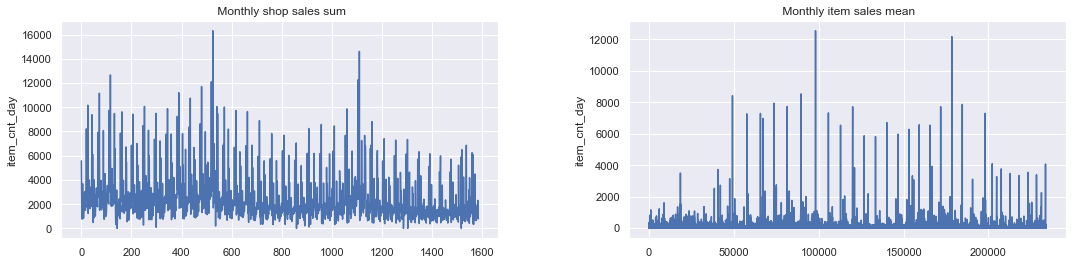

In [472]:

shop_sale = sales.groupby(["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame()
item_sale = sales.groupby(["date_block_num","item_id"])["item_cnt_day"].sum().to_frame()
item_sale = item_sale[item_sale['item_cnt_day'] < 25000]

sns.set(style='darkgrid')
ax=[None for i in range(2)]
fig=plt.figure(figsize=(18,4),facecolor='white')
gs=fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.5)
ax[0]=fig.add_subplot(gs[0,0])
ax[1]=fig.add_subplot(gs[0,1])
sns.lineplot(x=range(len(shop_sale)), y=shop_sale["item_cnt_day"], ax=ax[0]).set_title(" Monthly shop sales sum")
sns.lineplot(x=range(len(item_sale)), y=item_sale["item_cnt_day"], ax=ax[1]).set_title(" Monthly item sales mean")
plt.show()

In [493]:
# Best selling item id and name
item_cat
a2 = item_sale["item_cnt_day"][2]
item_argmax = a2[a2 == a2.max()].index
item[item["item_id"] == item_argmax[0]]

,item_name,item_id,item_category_id
6738,StarCraft II: Heart of the Swarm (дополнение) ...,6738,30


In [471]:
# Best selling shop id and name
shops[shops['shop_id'] == 31]

,shop_name,shop_id
31,"Москва ТЦ ""Семеновский""",31


---

## 4 Outliers

Sale volume outliers: [ 8057 20949  9242 19437  3731 11373  9249  9248]
Item price outliers: [11365  6066 13199]


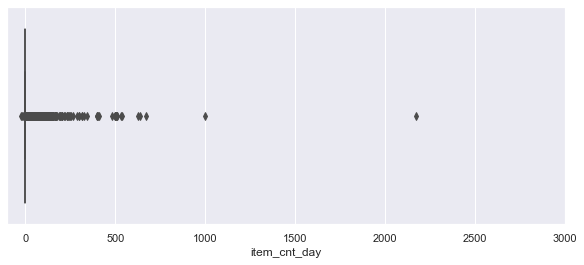

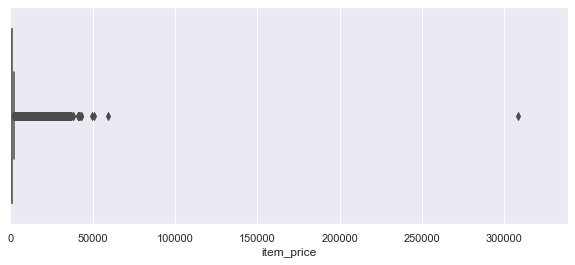

In [501]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=sales.item_cnt_day)
print('Sale volume outliers:',sales['item_id'][sales['item_cnt_day']>500].unique())

plt.figure(figsize=(10,4))
plt.xlim(sales.item_price.min(), sales.item_price.max()*1.1)
sns.boxplot(x=sales.item_price)
print('Item price outliers:',sales['item_id'][sales['item_price']>50000].unique())

### 5 Missing value & Error

#### 5.1 Missing value  
* No missing values found

In [39]:
sales.isnull().any()

date              False
date_block_num    False
shop_id           False
item_id           False
item_price        False
item_cnt_day      False
dtype: bool

In [40]:
shops.isnull().any()

shop_name    False
shop_id      False
dtype: bool

In [519]:
item.isnull().any()

item_name           False
item_id             False
item_category_id    False
dtype: bool

In [520]:
item_cat.isnull().any()

item_category_name    False
item_category_id      False
dtype: bool

In [521]:
sub.isnull().any()

ID                False
item_cnt_month    False
dtype: bool

#### 5.2 Error value  (Maybe)
* one price lower than 0  
* few shop_id didn't appear on sales(train) and test set  
* large item_id didn't appear on sales(train) and test set  

In [41]:
sales[sales["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [42]:
sales[sales['item_id'] == 2973]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
352,15.01.2013,0,25,2973,2499.00,13.0
353,16.01.2013,0,25,2973,2499.00,5.0
354,17.01.2013,0,25,2973,2499.00,3.0
355,18.01.2013,0,25,2973,2499.00,2.0
356,19.01.2013,0,25,2973,2499.00,3.0
...,...,...,...,...,...,...
1765321,22.06.2014,17,57,2973,1249.50,1.0
1782298,09.06.2014,17,47,2973,1249.00,1.0
1851765,04.07.2014,18,26,2973,1249.50,1.0
1923837,06.08.2014,19,6,2973,1249.50,1.0


In [43]:
def compare_df(df1, df2, names):
    print('Comparing ', names[2], 'on', names[0], ' and ', names[1])
    df1_list = list(df1[names[2]].drop_duplicates())
    df2_list = list(df2[names[2]].drop_duplicates())
    diff = [y for y in (df1_list + df2_list) if y not in df1_list] # Different
    print('Different:', diff)
    
    only_df1 = [x for x in df1_list if x not in df2_list]  
    only_df2 = [y for y in df2_list if y not in df1_list]  
    print(names[2], ' only occur in', names[0], only_df1)
    print(names[2], ' only occur in', names[1], only_df2)
    print('\n')
    return only_df1

In [45]:
# comparing shop_id
compare_df(sales, shops, ["sales", "shops", 'shop_id'])
compare_df(test, shops, ["test", "shops", 'shop_id'])
diff = compare_df(sales, test, ["sales", "test", 'shop_id'])

# comparing item_id (too much)
# compare_df(sales, item, ["sales", "item", 'item_id'])
# compare_df(test, item, ["test", "item", 'item_id'])
# diff_item = compare_df(sales, test, ["sales", "test", 'item_id'])

Comparing  shop_id on sales  and  shops
Different: []
shop_id  only occur in sales []
shop_id  only occur in shops []


Comparing  shop_id on test  and  shops
Different: [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]
shop_id  only occur in test []
shop_id  only occur in shops [0, 1, 8, 9, 11, 13, 17, 20, 23, 27, 29, 30, 32, 33, 40, 43, 51, 54]


Comparing  shop_id on sales  and  test
Different: []
shop_id  only occur in sales [23, 27, 29, 0, 1, 8, 13, 30, 32, 54, 43, 51, 17, 9, 40, 33, 20, 11]
shop_id  only occur in test []




## 6 Correlations

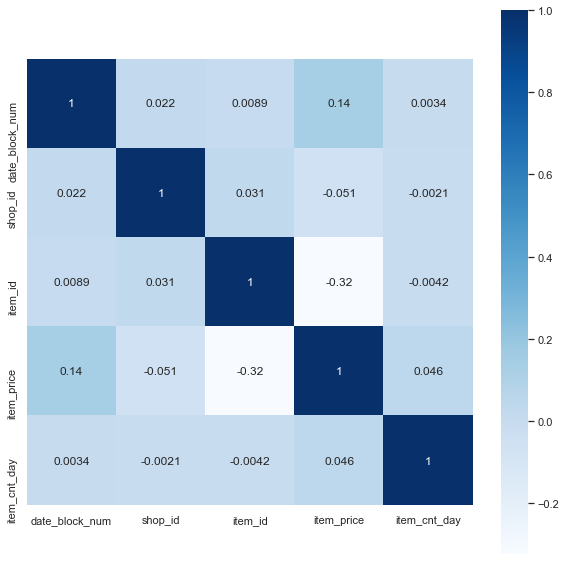

In [614]:
sales_corr_p = sales.corr('spearman')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(sales_corr_p,annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

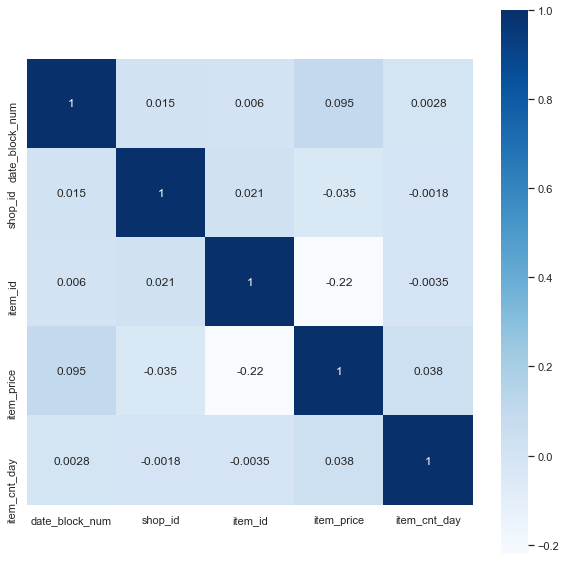

In [615]:
sales_corr_k = sales.corr('kendall')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(sales_corr_k, annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

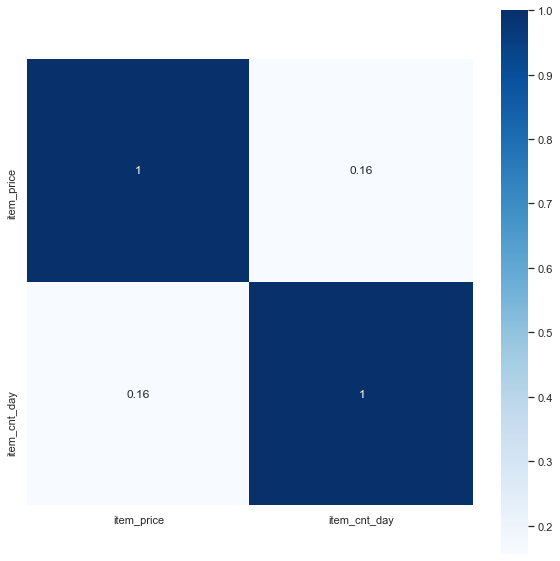

In [616]:
monthly_sales_p = monthly_sales.corr('spearman')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(monthly_sales_p, annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

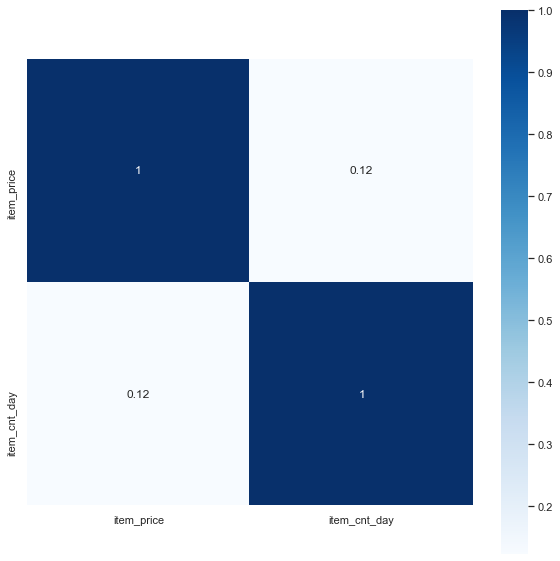

In [617]:
monthly_sales_k = monthly_sales.corr('kendall')
plt.subplots(figsize=(10,10),facecolor='w')
fig=sns.heatmap(monthly_sales_k, annot=True, vmax=1, square=True, cmap="Blues", fmt='.2g')

---

### Data preprocessing

item.csv & item_categories.csv  
* should join to training set (sales)

In [46]:
train = sales.join(item.set_index('item_id'), on='item_id').drop(columns=['item_name'])

In [47]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,02.01.2013,0,59,22154,999.00,1.0,37
1,03.01.2013,0,25,2552,899.00,1.0,58
2,05.01.2013,0,25,2552,899.00,-1.0,58
3,06.01.2013,0,25,2554,1709.05,1.0,58
4,15.01.2013,0,25,2555,1099.00,1.0,56
...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55
2935845,09.10.2015,33,25,7460,299.00,1.0,55
2935846,14.10.2015,33,25,7459,349.00,1.0,55
2935847,22.10.2015,33,25,7440,299.00,1.0,57


shops.csv  
* join the city name

In [48]:
city = DataFrame.copy(shops)
reg = "\s"

for i in range(len(city['shop_name'])):
    shopName = city['shop_name'][i]
    index = re.search(reg, shopName).span()[0]
    city['shop_name'][i] = shopName[:index]
    
city.columns = ["city_name", "shop_id"]
city.loc[city['city_name'] == '!Якутск', 'city_name'] = 'Якутск'
city_id = city['city_name'].drop_duplicates().reset_index(drop=True)
for i in range(len(city_id)):
    city.loc[city['city_name'] == city_id[i], 'city_id'] = int(i)

train = train.join(city.set_index('shop_id'), on='shop_id').drop(columns=['city_name'])

In [49]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
0,02.01.2013,0,59,22154,999.00,1.0,37,30.0
1,03.01.2013,0,25,2552,899.00,1.0,58,14.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,14.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,14.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,14.0
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,14.0
2935845,09.10.2015,33,25,7460,299.00,1.0,55,14.0
2935846,14.10.2015,33,25,7459,349.00,1.0,55,14.0
2935847,22.10.2015,33,25,7440,299.00,1.0,57,14.0


drop outlier

In [50]:
train = train[train['item_cnt_day'] < 2000]
train = train[train['item_price'] < 300000]
train = train[train['item_price'] > 0]

In [51]:
train_test = DataFrame.copy(train)

In [52]:
monthly_shop_sales=train.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
monthly_shop_sales=monthly_shop_sales.unstack(level=1).fillna(0)
monthly_shop_sales.to_csv('1.csv')

In [53]:
train_test.loc[train_test.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train_test.loc[train_test.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train_test.loc[train_test.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [54]:
train_test

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
0,02.01.2013,0,59,22154,999.00,1.0,37,30.0
1,03.01.2013,0,25,2552,899.00,1.0,58,14.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,14.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,14.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,14.0
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,14.0
2935845,09.10.2015,33,25,7460,299.00,1.0,55,14.0
2935846,14.10.2015,33,25,7459,349.00,1.0,55,14.0
2935847,22.10.2015,33,25,7440,299.00,1.0,57,14.0


## Groupby 'date_block_num','shop_id','item_id','item_category_id', 'city_id'

In [55]:
train_item = train_test.drop(columns='date')
train_item = train_item.groupby(['date_block_num','shop_id','item_id','item_category_id', 'city_id'])["date_block_num","shop_id", "item_id","item_category_id", "city_id", "item_price","item_cnt_day"].agg({'item_price':sum, 'item_cnt_day':sum})

train_item.to_csv('../datasets/train_groupby.csv')
train_groupby=pd.read_csv("../datasets/train_groupby.csv")

/var/folders/z4/snjl44yd2sz6dxh5_3nlrgyh0000gn/T/ipykernel_10715/505073374.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [56]:
train_groupby

,date_block_num,shop_id,item_id,item_category_id,city_id,item_price,item_cnt_day
0,0,2,27,19,1.0,2499.0,1.0
1,0,2,33,37,1.0,499.0,1.0
2,0,2,317,45,1.0,299.0,1.0
3,0,2,438,45,1.0,299.0,1.0
4,0,2,471,49,1.0,798.0,2.0
...,...,...,...,...,...,...,...
1609118,33,59,22087,83,30.0,357.0,6.0
1609119,33,59,22088,83,30.0,238.0,2.0
1609120,33,59,22091,83,30.0,179.0,1.0
1609121,33,59,22100,42,30.0,629.0,1.0


---

### insert missing item

In [22]:
train_groupby = train_groupby.sort_values(by=['shop_id'])

,date_block_num,shop_id,item_id,item_category_id,city_id,item_price,item_cnt_day
0,0,2,27,19,1.0,2499.0,1.0
1067250,20,2,2269,30,1.0,1118.0,2.0
1067249,20,2,2268,20,1.0,2799.0,1.0
1067248,20,2,2267,19,1.0,3998.0,2.0
1067247,20,2,2253,19,1.0,1399.0,1.0
...,...,...,...,...,...,...,...
1416369,27,59,4427,55,30.0,299.0,1.0
1416370,27,59,4431,55,30.0,299.0,1.0
1416371,27,59,4466,19,30.0,979.0,1.0
1416362,27,59,4348,19,30.0,980.0,1.0


In [129]:
sales_dict = {}
shop_mark = -100
item_mark = -100
for line in train_groupby.iloc():
    shop  = line['shop_id']
    item = line['item_id']
    if shop == shop_mark:
        continue
    else:
        shop_mark = shop
        if shop not in sales_dict.keys():
            sales_dict[shop] = [item]
        else:
            if item not in sales_dict[shop]:
                sales_dict[shop].append(item)

/var/folders/z4/snjl44yd2sz6dxh5_3nlrgyh0000gn/T/ipykernel_1092/204791130.py:6: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



In [126]:
# Item number of each block
for block in range(34):
    shop_id = train_groupby[train_groupby['date_block_num'] == block]['shop_id']
    for shop in shops['shop_id']:
        if i not in shop_id:
            print(i)

63224
59935
63977
54638
53296
56196
58035
58022
51575
51090
51460
66275
53320
47704
49291
44740
45766
46481
45756
46439
40423
42595
45755
59275
46775
41390
40464
32875
32220
31909
33527
33486
29678
31531


---

### remove different values

In [57]:
diff = compare_df(train_test, test, ["sales", "test", 'shop_id'])

Comparing  shop_id on sales  and  test
Different: []
shop_id  only occur in sales [23, 27, 29, 8, 13, 30, 32, 54, 43, 51, 17, 9, 40, 33, 20]
shop_id  only occur in test []




In [32]:
for i in diff:
    train_test[train_test['shop_id'] == i] = -1
train_test = train_test[train_test['shop_id'] > 0]

NameError: name 'diff' is not defined

In [ ]:
monthly_shop_sales=train_test.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
monthly_shop_sales=monthly_shop_sales.unstack(level=1).fillna(0)
monthly_shop_sales.to_csv('shopSales.csv')

In [ ]:
train_test

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
0,02.01.2013,0,59,22154,999.00,1.0,37,30.0
1,03.01.2013,0,25,2552,899.00,1.0,58,14.0
2,05.01.2013,0,25,2552,899.00,-1.0,58,14.0
3,06.01.2013,0,25,2554,1709.05,1.0,58,14.0
4,15.01.2013,0,25,2555,1099.00,1.0,56,14.0
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,55,14.0
2935845,09.10.2015,33,25,7460,299.00,1.0,55,14.0
2935846,14.10.2015,33,25,7459,349.00,1.0,55,14.0
2935847,22.10.2015,33,25,7440,299.00,1.0,57,14.0


In [23]:
diff_item = compare_df(train_test, test, ["train_test", "test", 'item_id'])
for i in diff_item:
    train_test[train_test['item_id'] == i] = -1
train_test = train_test[train_test['item_id'] > 0]

In [ ]:
train_test

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,city_id
0,02.01.2013,0,59,22154,999.0,1.0,37,30.0
10,03.01.2013,0,25,2574,399.0,2.0,55,14.0
11,05.01.2013,0,25,2574,399.0,1.0,55,14.0
12,07.01.2013,0,25,2574,399.0,1.0,55,14.0
13,08.01.2013,0,25,2574,399.0,2.0,55,14.0
...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0,55,14.0
2935845,09.10.2015,33,25,7460,299.0,1.0,55,14.0
2935846,14.10.2015,33,25,7459,349.0,1.0,55,14.0
2935847,22.10.2015,33,25,7440,299.0,1.0,57,14.0


In [ ]:
train_test.to_csv('../datasets/train.csv')

group by

In [ ]:
train_groupby.groupby(["date_block_num"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/var/folders/z4/snjl44yd2sz6dxh5_3nlrgyh0000gn/T/ipykernel_72300/3937679507.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,item_price,item_cnt_day
date_block_num,,
0,729.253430,20612.0
1,764.852777,22163.0
2,761.001261,31599.0
3,707.141020,20704.0
4,648.836525,23322.0
5,665.842670,32505.0
6,663.178051,29960.0
7,643.712405,32344.0
8,789.023964,44102.0


### Data visualization

In [58]:
f_p = plt.gca()
f_p.bar(range(len(monthly_sales_simple['item_cnt_day'])),monthly_sales_simple['item_cnt_day'], width=0.7, color='b')
plt.show()

KeyboardInterrupt: 